# Analyzing ECG recordings from student volunteers

### Erin C. McKiernan<sup>1</sup>, Jorge Humberto Arce Rincón<sup>1</sup>, Araceli Torres Pérez<sup>1</sup>, Marco A. Herrera-Valdez<sup>2</sup>

<sup>1</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México <br/>
<sup>2</sup> Departamento de Matemáticas, Facultad de Ciencias, Universidad Nacional Autónoma de México <br/>

## Background
This Jupyter notebook is written to accompany our manuscript:

* McKiernan, E.C., Arce Rincón, J.H., Torres Pérez, A., & Herrera-Valdez, M.A. A method for analyzing physiological data with multiple non-independent observations. 

This manuscript analyzes two different data sets, one being Drosophila muscle recordings, and the other being human electrocardiogram (ECG) recordings. Here we look only at the human ECG data. (We have a separate notebook analyzing the Drosophila data.) The methodology for these recordings is detailed in our paper. Briefly, ECGs were recorded from student volunteers using a Zephyr Bioharness before, during, and after exercise on a stationary bicycle. The time elapsed between successive cardiac cycles was measured as the RR interval. During exercise, volunteers were asked to maintain a specific intensity (power) level, as measured in watts. 

## Setting up the notebook
First, we import all the packages needed for computing, graphing, etc.

In [141]:
from repeatedMeasures_baseCode import *
# command to view figures in Jupyter notebook
%matplotlib inline 

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 14 # fontsize for figure labels
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
#
dataPath = '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/'

In [142]:
# run following code if you want figures centered, or comment out for default left-aligned
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [143]:
# for reproducibility purposes, print python and package versions
! python3 --version

#! pip3 install print-versions # works for python >= 3.8
#from print_versions import print_versions
#print_versions(globals())

Python 3.13.3


In [144]:
# also for reproducibility, print jupyter specs
!jupyter --version

Selected Jupyter core packages...
IPython          : 9.2.0
ipykernel        : 6.29.5
ipywidgets       : not installed
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server   : 2.15.0
jupyterlab       : 4.4.2
nbclient         : 0.10.2
nbconvert        : 7.16.6
nbformat         : 5.10.4
notebook         : 7.4.1
qtconsole        : not installed
traitlets        : 5.14.3


## Graphing the data
Now, we open a file to see an example of the data. In this case, we are not graphing the raw ECG recordings, but rather the RR intervals extracted from the recordings, to see how they change over the course of the different rest and exercise periods. We start by opening the text file and splitting the data into two lists, one with the time stamps of the events and the other with the RR intervals (in milliseconds).

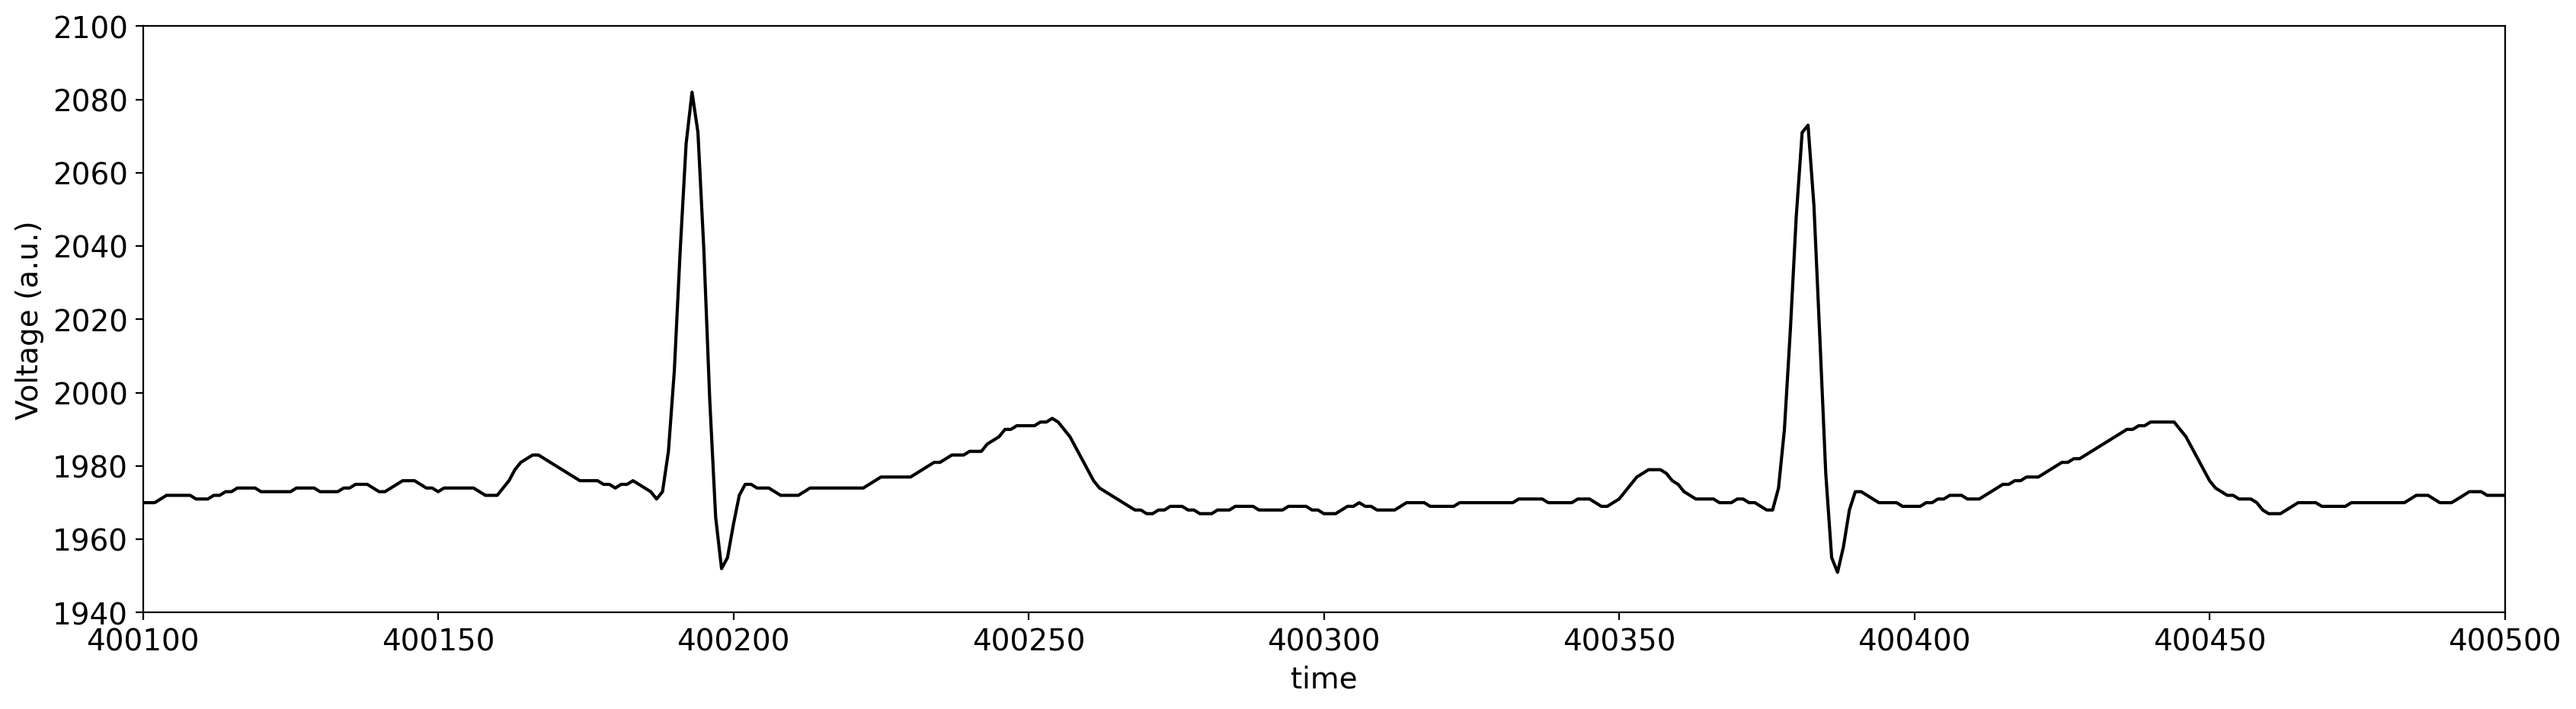

In [246]:
import csv

def graph_csv_column(file_path):
    """Reads a single-column CSV and plots the data."""
    data = []
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            try:
                data.append(float(row[0]))  # Convert to float, assuming numerical data
            except ValueError:
                print(f"Skipping non-numeric value: {row[0]}")
                continue

    if data:
        plt.figure(figsize=(20,5))
        plt.plot(data,color='k')
        plt.xlim(400100,400500)
        plt.ylim(1940,2100)
        plt.xlabel("time")
        plt.ylabel("Voltage (a.u.)")
        plt.show()
    else:
        print("No valid data to plot.")

# Example usage:
file_path = '/Users/erin/Manuscripts/inPrep/repeatedMeasures/data/ECG1.csv'  # Replace with your CSV file path
graph_csv_column(file_path)

In [174]:
# open text file data
dataFile = 'S01_60W.txt'
with open(dataPath+dataFile) as f:
    lines = f.readlines()
    times = [line.split()[0] for line in lines]
    RRs = [line.split()[1] for line in lines]

The data is extracted as strings, so we have to convert the strings to floats to give us numbers we can work with and on which we can perform calculations.

In [175]:
# convert RR intervals to floats
RRdata=[]
for x in RRs:
    data = float(x)
    RRdata.append(data)

# convert time stamps to floats    
timesData=[]
for x in times:
    data = float(x)
    timesData.append(data)
    
# uncomment following to print times and RR intervals
# print(timesData)
# print(RRdata)

Now, we plot the RR intervals for each cardiac cycle. We can see the initial rest period (0-5m), followed by light exercise (7-9m), more intense exercise (9-20m), and then recovery (starting at 20m). We are going to focus on the final minutes of exercise from 17-20m, so we highlight that period in green.

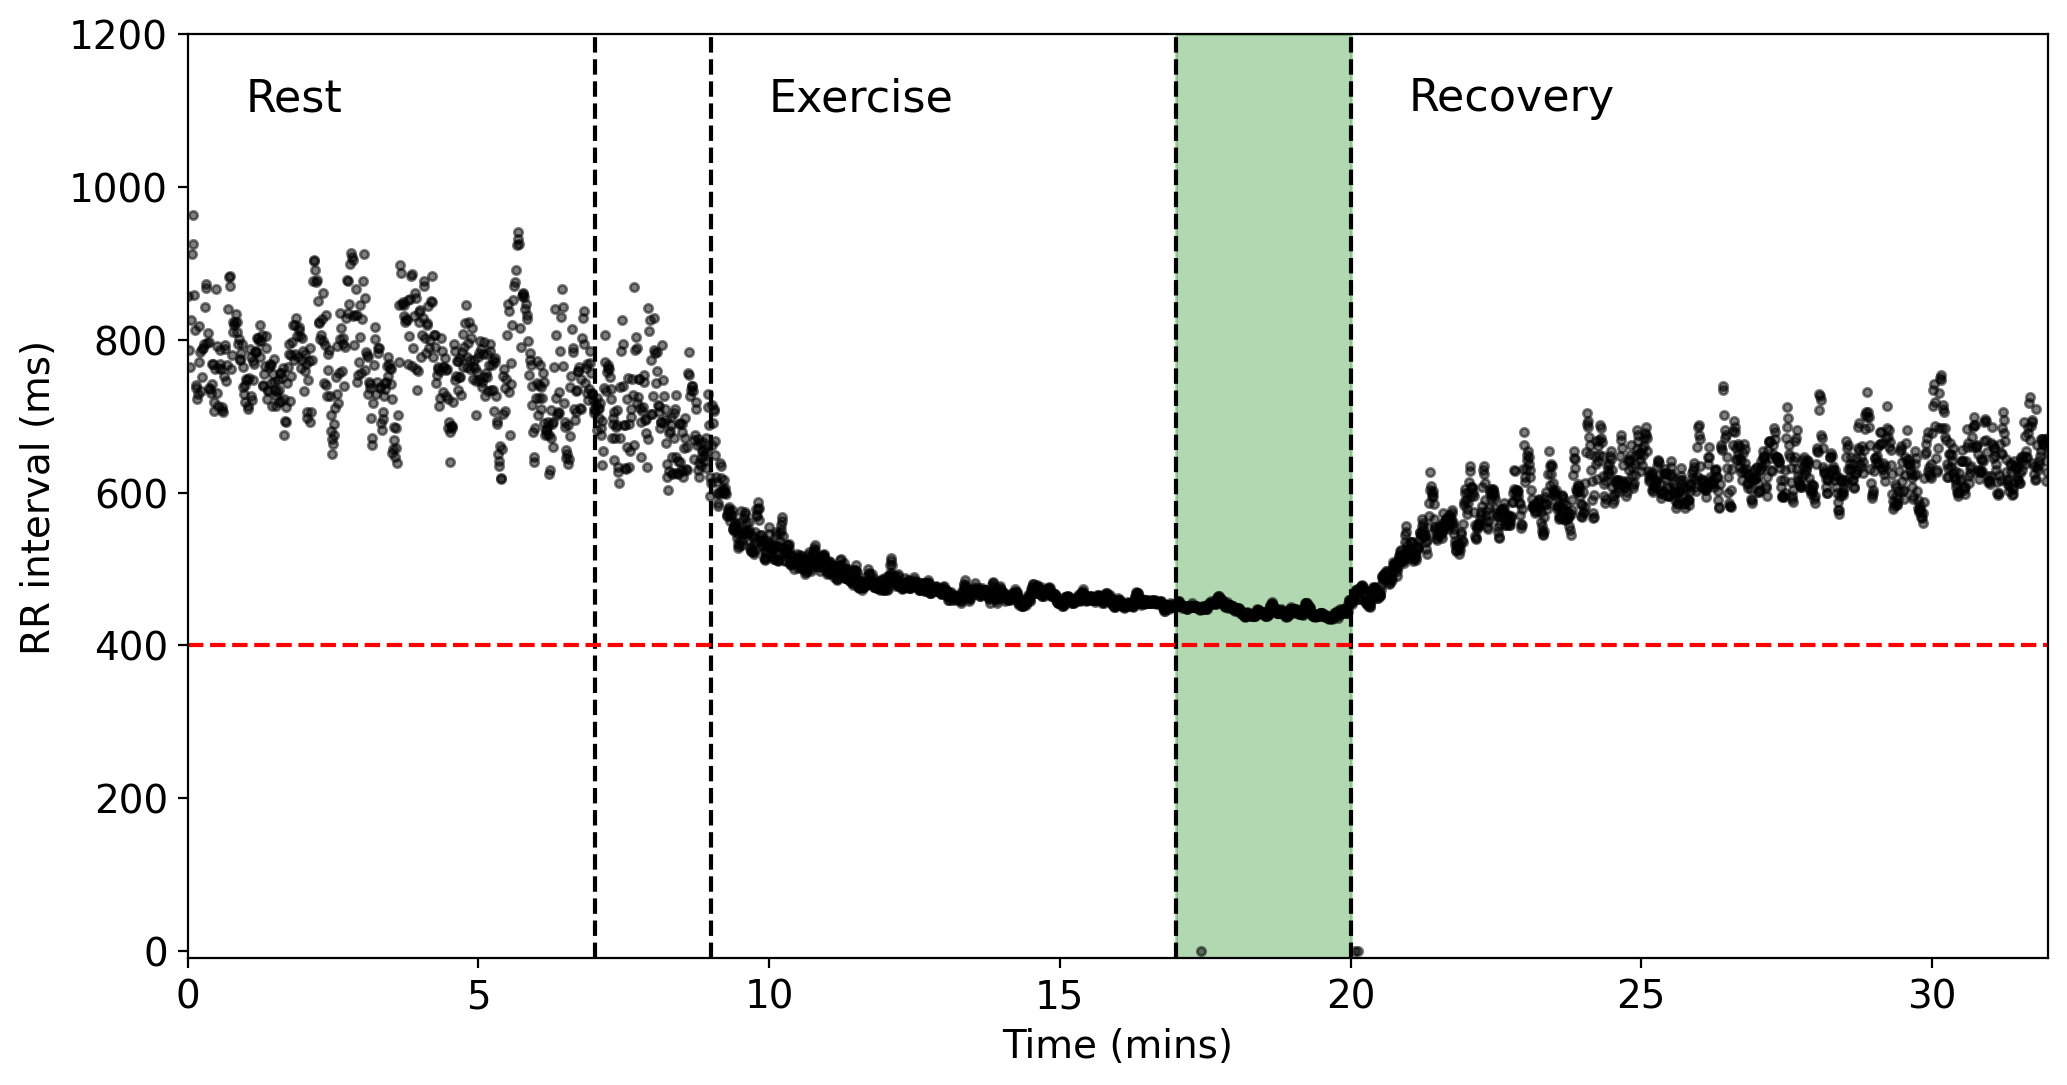

In [176]:
# plot data
plt.figure(figsize=(12,6))
plt.plot(timesData,RRdata,'.',color='k',alpha=0.5)
plt.grid(False)
plt.xlim(0,max(timesData))
plt.ylim(-10,1200)
plt.xlabel('Time (mins)')
plt.ylabel('RR interval (ms)')
plt.text(1,1100,'Rest',fontsize=16)
plt.text(10,1100,'Exercise',fontsize=16)
plt.text(21,1100,'Recovery',fontsize=16)
plt.axvline(x=7,color='k',ls='--')
plt.axvline(x=9,color='k',ls='--')
plt.axvline(x=17,color='k',ls='--')
plt.axvline(x=20,color='k',ls='--')
plt.axhline(y=400,color='r',ls='--')
plt.axvspan(17, 20,color='g',alpha=0.3);

We can see that there are some RR intervals measured as lasting 0ms. These come from processes like artifact removal, or issues with R-peak detection. We can check how many zeros are present in the raw data by running the following. 

In [177]:
count_zeros = RRdata.count(0) 
print(count_zeros) 

3


We can remove these outliers by searching for and extracting the zeros from the dataset.

In [178]:
RRdata_rem = [i for i in RRdata if i != 0]

Since we removed values from the RR data set, we should do the same for the times stamps. We can find the indices at which the RR intervals were zero, and then remove these values from the time dataset. (Be careful not to run this more than once, or it will keep removing times.) Then, we recalculate the times before we replot the data. 

In [179]:
zeroInds= [i for i, n in enumerate(RRdata) if n == 0]
print(zeroInds)

for i in sorted(zeroInds,reverse=True):
    del timesData[i]
    
print(len(RRdata_rem))
print(len(timesData))

[1764, 2119, 2123]
3298
3298


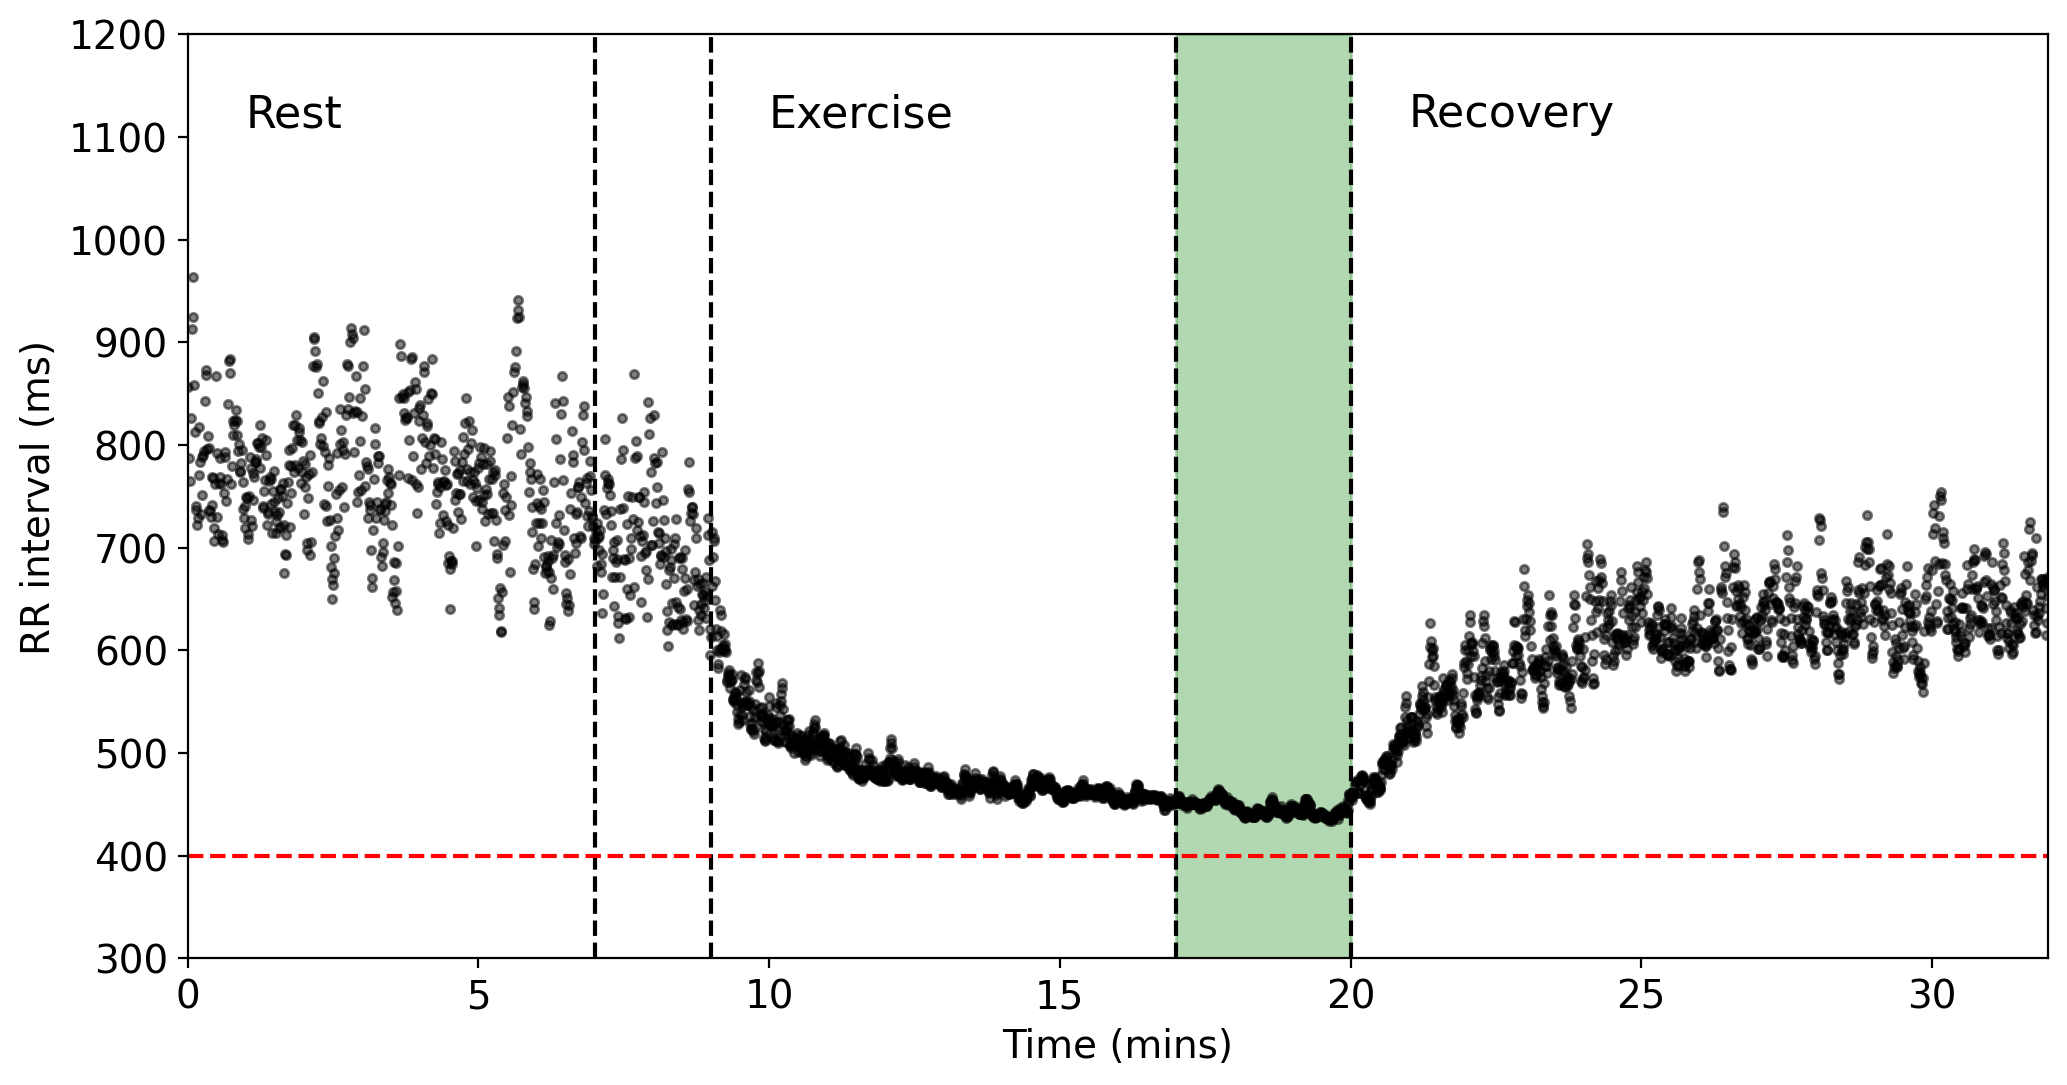

In [180]:
# replot data
plt.figure(figsize=(12,6))
plt.plot(timesData,RRdata_rem,'.',color='k',alpha=0.5)
plt.grid(False)
plt.xlim(0,max(timesData))
plt.ylim(300,1200)
plt.xlabel('Time (mins)')
plt.ylabel('RR interval (ms)')
plt.text(1,1110,'Rest',fontsize=16)
plt.text(10,1110,'Exercise',fontsize=16)
plt.text(21,1110,'Recovery',fontsize=16)
plt.axvline(x=7,color='k',ls='--')
plt.axvline(x=9,color='k',ls='--')
plt.axvline(x=17,color='k',ls='--')
plt.axvline(x=20,color='k',ls='--')
plt.axhline(y=400,color='r',ls='--')
plt.axvspan(17,20,color='g',alpha=0.3);

## Extracting data from multiple files
Next, we want to extract the same data we see above from all the volunteers in the sample. To do this, we set up a function that will perform the steps above -- extract the data, count and remove the zeros from the RR values, and save the new processed dataset.

In [181]:
# set up function to extract and process data
def getRRData(filename):
    
    # open text file data
    with open(file=filename) as f:
        lines = f.readlines()
        times = [line.split()[0] for line in lines]
        RRs = [line.split()[1] for line in lines]
    
    # convert RR intervals to floats
    RRdata=[]
    for x in RRs:
        data = float(x)
        RRdata.append(data)

    # convert times to floats    
    timesData=[]
    for x in times:
        data = float(x)
        timesData.append(data)
     
    # count zeros
    count_zeros = RRdata.count(0) 
    #print(count_zeros)
    
    # remove zeros
    RRdata_rem = [i for i in RRdata if i != 0]
    zeroInds= [i for i, n in enumerate(RRdata) if n == 0]
    for i in sorted(zeroInds,reverse=True):
        del timesData[i]
        
    # save data
    measures={'RRdata_rem':RRdata_rem,
              'timesData':timesData}
    
    return measures

Next, we want to find all the files from which we will extract data. We have these files organized in a single folder, and saved with a common filename structure. For each volunteer, we use the prefix 'Sn', where 'n' is the subject number. Following this, the filename indicates the exercise intensity level. So, if we do a search for filenames that contain the strong '60w', then this should pull all the files for all the subjects who have data at that intensity level. We get the final list of files to loop over by joining the file names with their directory path. 

In [182]:
# find all files for different subjects, single exercise watt level (e.g. 60w)
# specify the watt level
watts2batch=[]
for file in os.listdir(dataPath):
    filename = os.fsdecode(file)
    if '60W' in filename: # change number if you want a different watt level
        watts2batch.append(filename)
watts2batch.sort()

# get complete filenames
files2batch=[]
for n in watts2batch:
    filename= os.path.join(dataPath, n)
    files2batch.append(filename)
    
print(files2batch)

['/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S01_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S02_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S03_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S04_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S05_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S06_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S07_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S08_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S09_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S10_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forRepo/data/human-ECG/S11_60W.txt', '/Users/erin/Manuscripts/inPrep/repeatedMeasures/forR

Now we use the function we established above to extract data from all the files (subjects) in our list. 

In [183]:
# process data for all files at same exercie level
sameLevels=[]
for n in files2batch:
    data=getRRData(filename=n)
    sameLevels.append(data)

We could analyze different periods during the experiment. But, for now, we are going to focus just on the exercise period, and the activity during that period that is the most stable, i.e. the last three minutes of exercise (17-20m). Since the time stamps are different for each subject, we have to first find the indices that correspond to this 17-20m period for each subject, and then use these indices to pull the corresponding RR intervals. We can then plot the results to see how the RR intervals vary during this period for different subjects.

In [184]:
# find indices corresponding to 17-20m for each subject
starts=[]
ends=[]
for n in range(0,len(sameLevels)):
    inds2 = [idx for idx,val in enumerate(sameLevels[n]['timesData']) if val >= 17 and val <= 20]
    s2=(min(inds2))
    e2=(max(inds2))
    starts.append(s2)
    ends.append(e2)

# use indices to pull RR intervals for that same period 
exerData=[]
for n in range(0,len(sameLevels)):
    datapts=sameLevels[n]['RRdata_rem'][starts[n]:ends[n]]
    exerData.append(datapts)

# uncomment to print data    
# print(exerData)

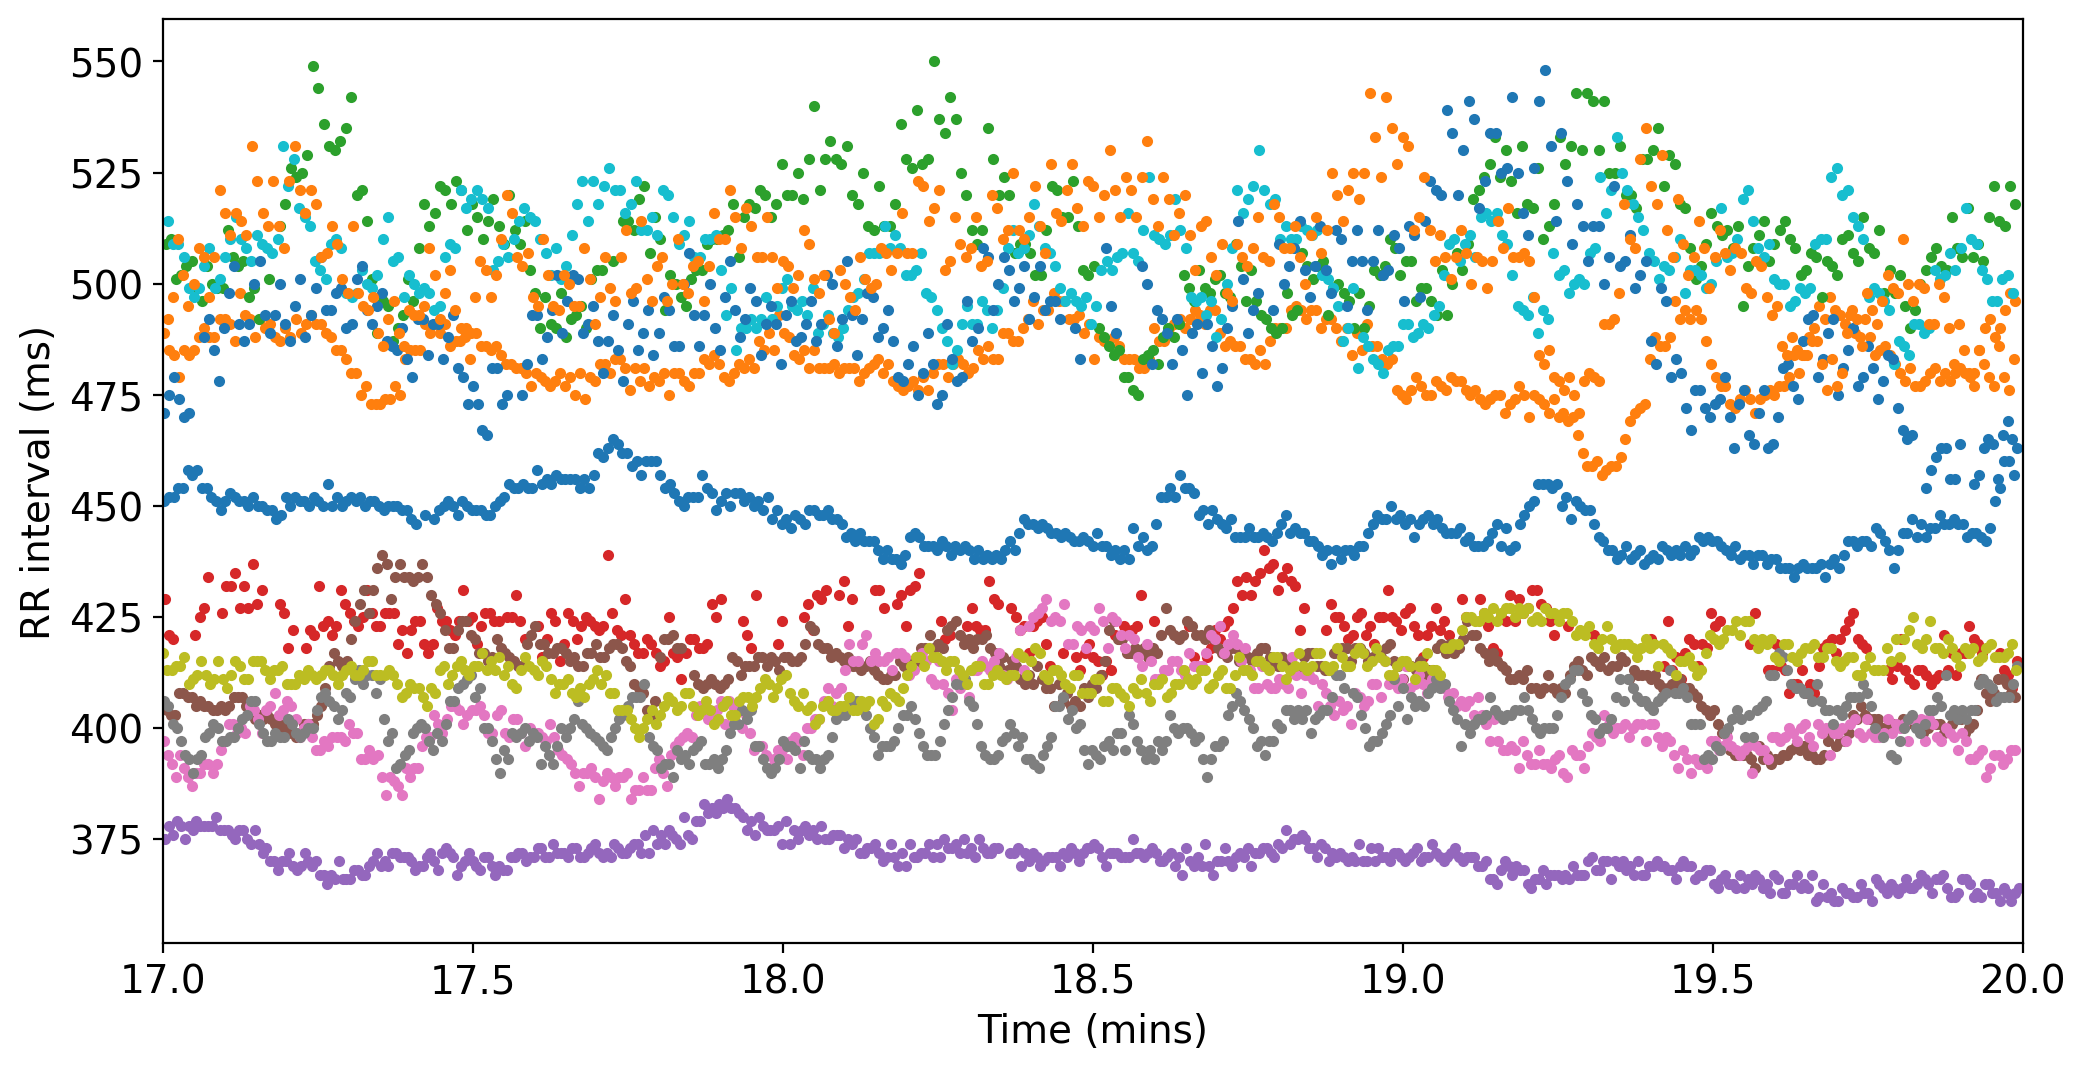

In [185]:
# plot data from 17-20m; each color is a different subject, only plotting 12 for visibility
plt.figure(figsize=(12,6))
for n in range(0,12):
    plt.plot(sameLevels[n]['timesData'][starts[n]:ends[n]],exerData[n],'.')
plt.xlim(17,20)
plt.xlabel('Time (mins)')
plt.ylabel('RR interval (ms)');

We can print the length of the data for each subject, i.e. the number of RR intervals in the 17-20m period. This shows us whether some subjects have larger n's than others.

In [186]:
# print number of RRs for each subject during the time interval
sampleSizes=[]
for n in range(0,len(exerData)):
    numRR=len(exerData[n])
    sampleSizes.append(numRR)

print(sampleSizes)

[400, 372, 348, 324, 483, 433, 446, 446, 435, 355, 346, 355, 353, 366, 386, 410, 325, 376, 341, 478, 398, 377, 362, 307, 328, 397, 462]


In [187]:
# print minimum sample size, max, difference between the two, and the fold difference
minn=min(sampleSizes)
maxn=max(sampleSizes)
diffn=maxn-minn
timesn=maxn/minn

print(minn)
print(maxn)
print(diffn)
print(round(timesn, 2))

307
483
176
1.57


We can see that each subject has a different number of RR intervals. Some subjects have more (e.g. 483), while others have less (e.g. 307), representing a maximum 1.5-fold difference. This will be important later when we look at how data is handled, i.e. pooled or not pooled.

## Defining functions
Before we can analyze the data we set up two classes, one with functions that deal with a single sample (i.e. RR data from one subject) and a second class with functions that deal with multiple samples. The overall focus of our analysis is on calculating the empirical distribution function (EDF) of the samples. The EDF "can be used to describe a sample of observations of a given variable. Its value at a given point is equal to the proportion of observations from the sample that are less than or equal to that point" (https://www.statlect.com/asymptotic-theory/empirical-distribution). The EDF "is an estimate of the cumulative distribution function that generated the points in the sample" (https://en.wikipedia.org/wiki/Empirical_distribution_function). Our strategy (explained in more detail in our accompanying paper) is to first calculate the EDF for a single subject from a single group (e.g. active or sedentary). Then, we average over those EDFs to generate the group EDF. We will look at this in more detail in the sections below. 

## Examining issues with pooling data
Many studies that deal with this type of repeated measures data end up pooling observations from multiple subjects together for analysis. However, before we look at that, we need to have groups to compare. Up to this point, we have been dealing with the ECG recordings as if they come from a homogeneous group of subjects. However, the subjects for this study could be divided into at least two groups, deemed active or sedentary based on their heart rate variability, exercise tolerance, and self reports of physical activity. We have the subject numbers for each of these, so we can specify the indices in the larger sample to then divide into active and sedentary groups and place their data into separate arrays. 

In [188]:
# specify which subjects in data are active versus sedentary
actInds=[0,1,2,3,11,12,13,17,20,22,24] # active
sedInds=[4,5,6,7,8,14,15,19,25,26] # sedentary

In [189]:
# extract data for active subjects
actives = [exerData[i] for i in actInds]
print(len(actives)) # sample size

# extract data for sedentary subjects
sedentaries = [exerData[i] for i in sedInds]
print(len(sedentaries)) # sample size

11
10


In [190]:
# create dictionary with keys for the two groups
groups={'act':actives,'sed':sedentaries}
#print(groups['act'])

<Axes: ylabel='Density'>

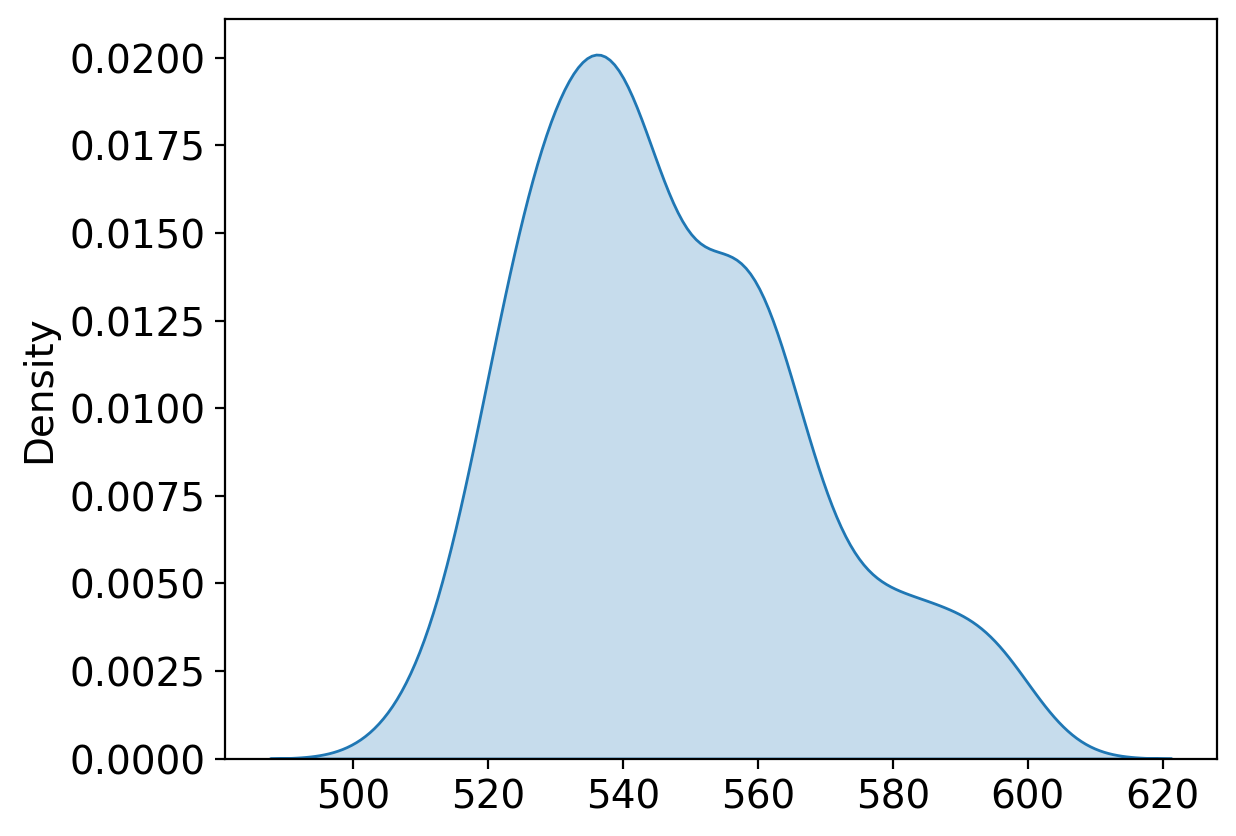

In [209]:
sns.kdeplot(groups['act'][10],fill=bool,legend=True,linewidth=1.0)

In [210]:
len(groups['act'][10])

328

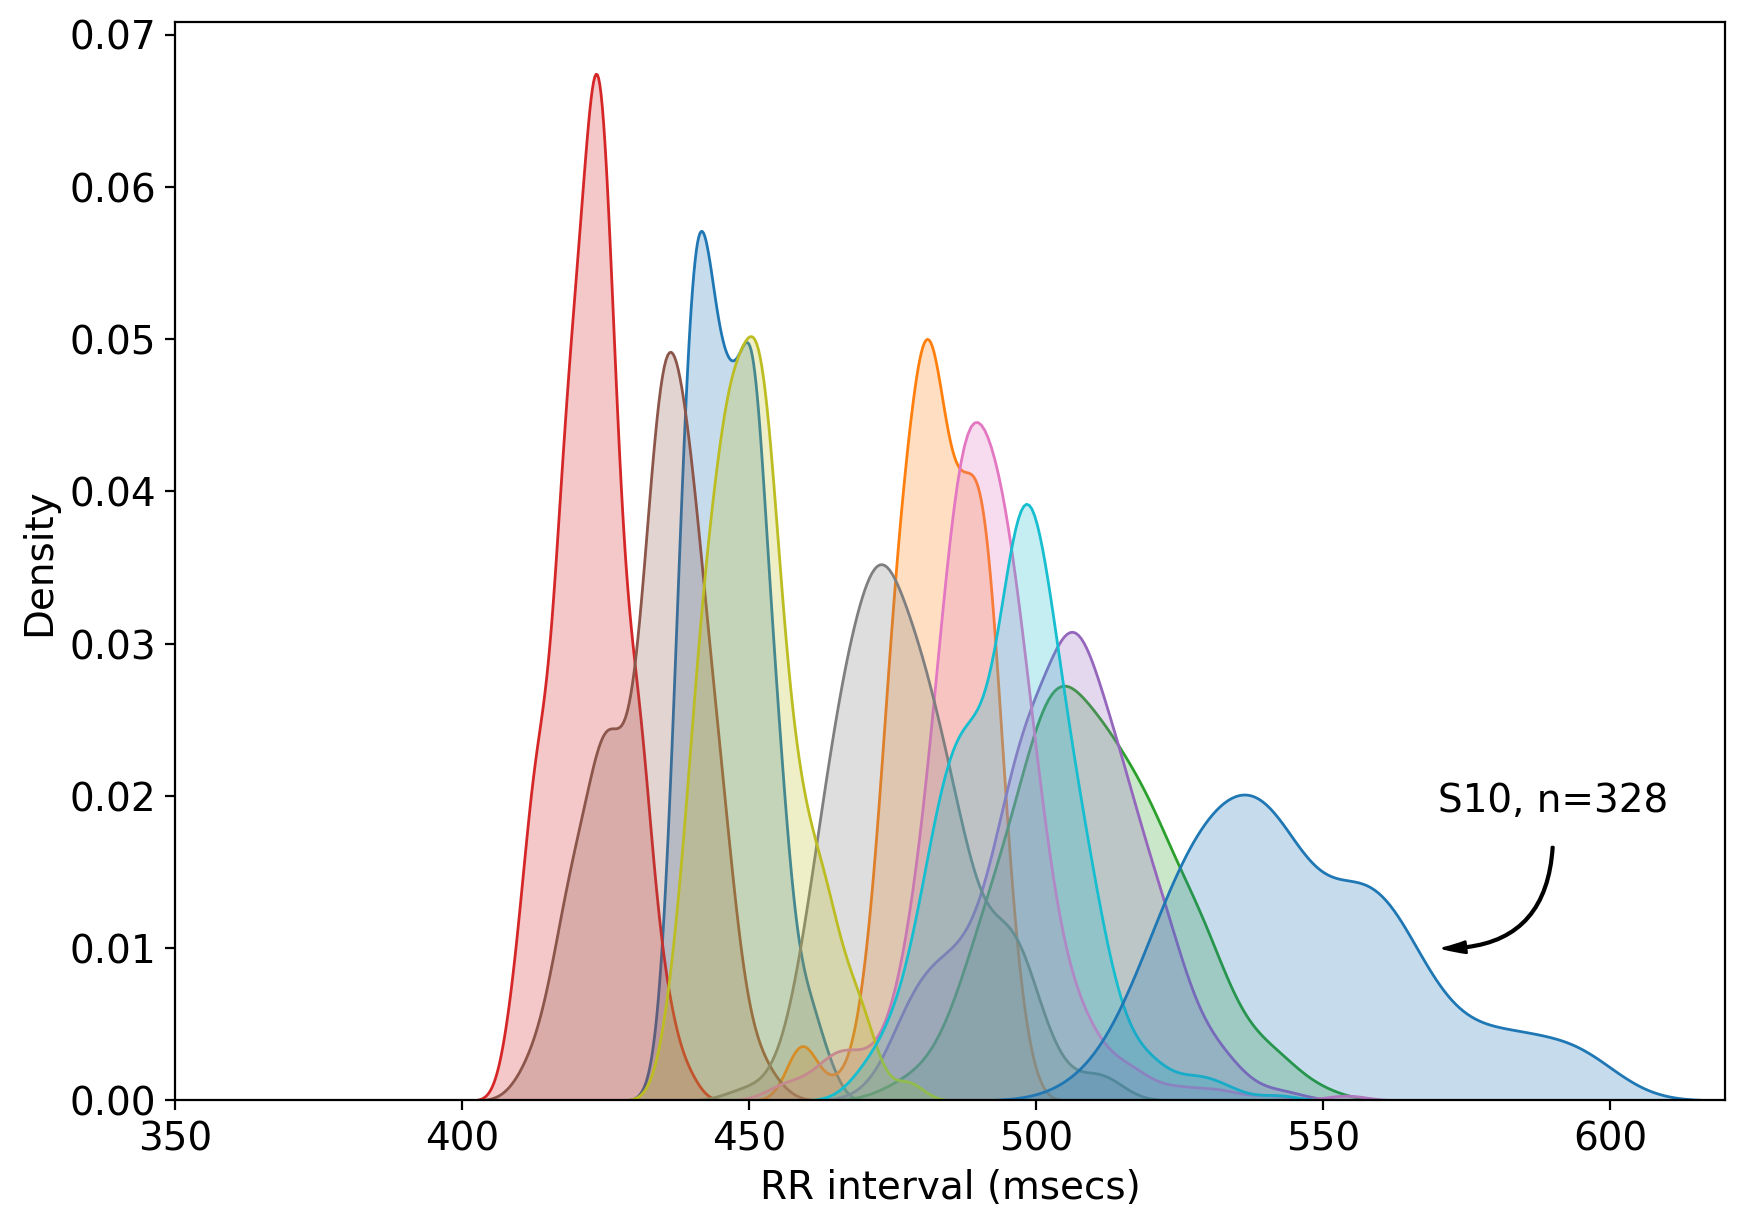

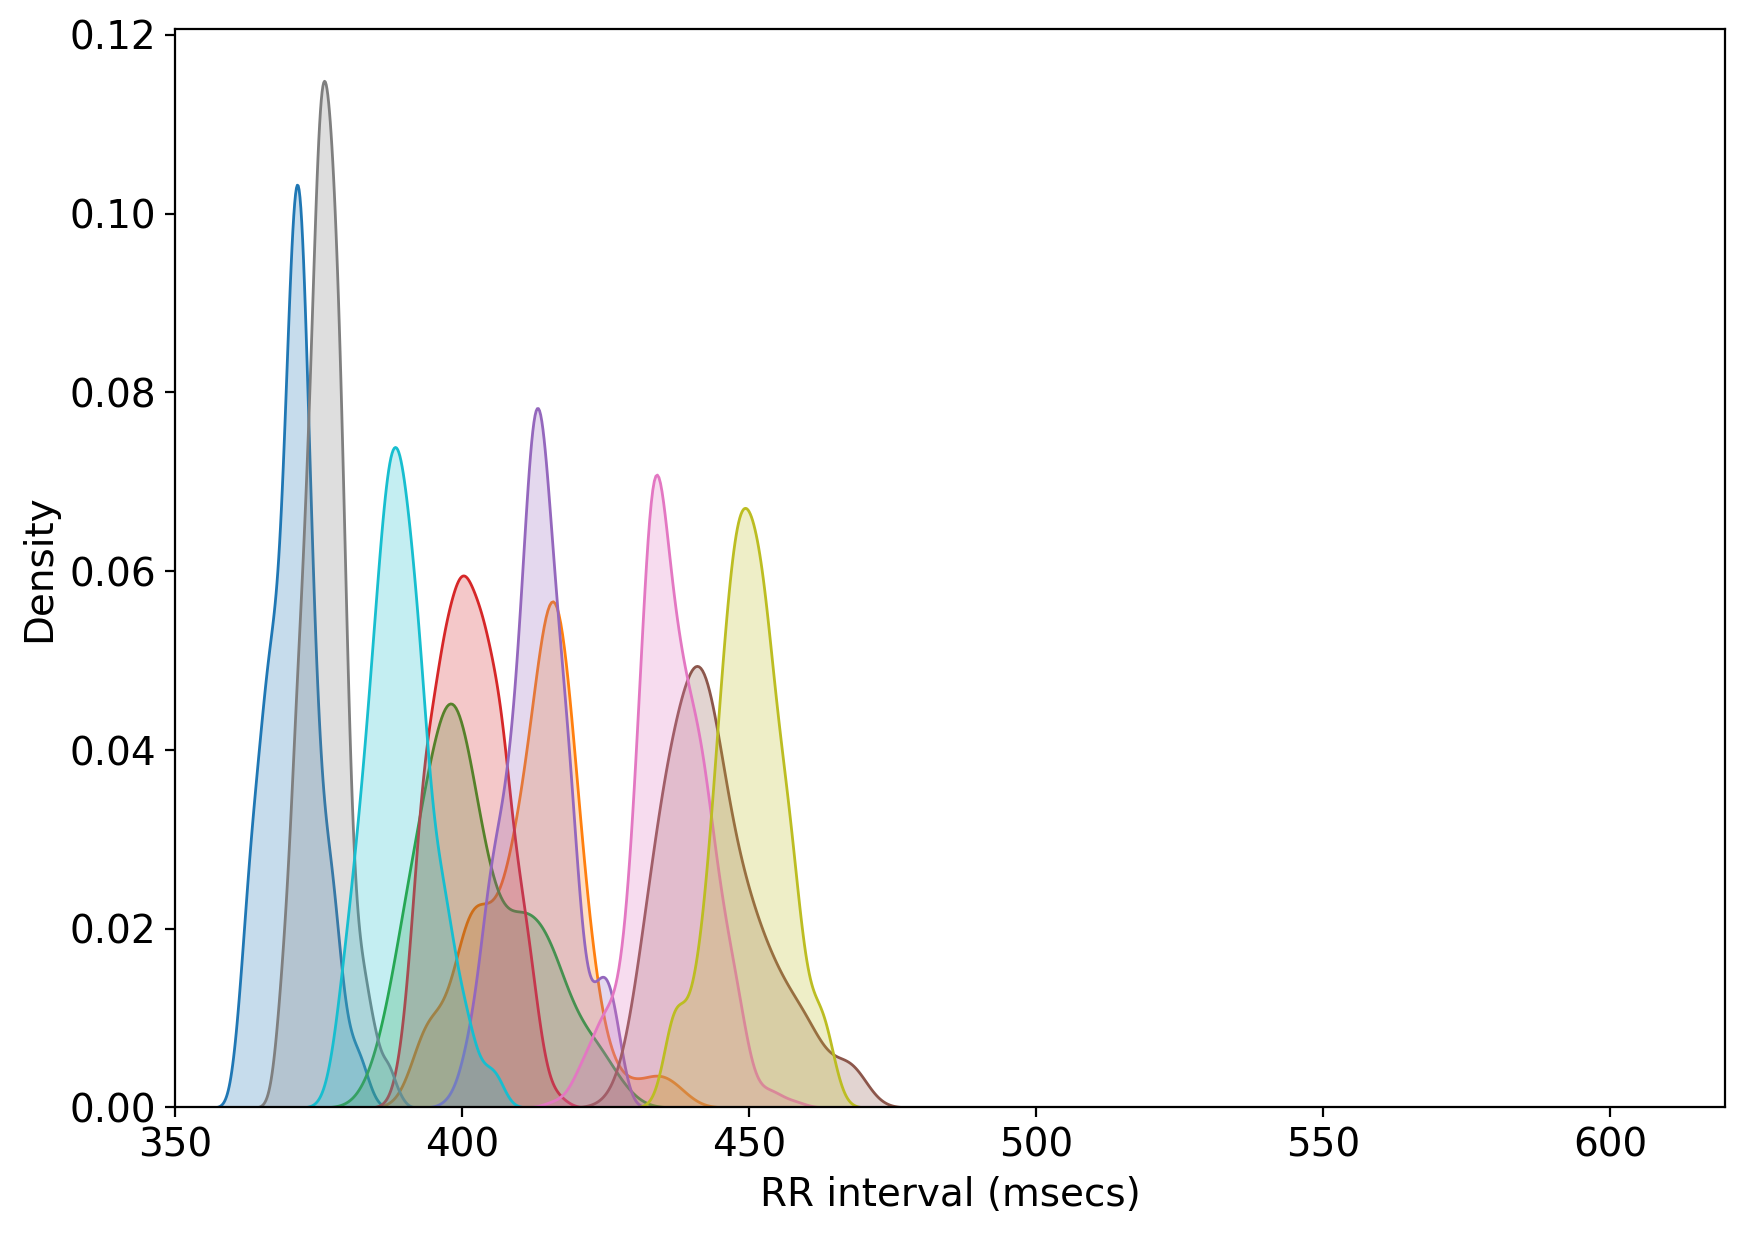

In [213]:
# plot KDEs for each active subject
plt.figure(figsize=(10,7))
#plt.title('Active subjects')
for n in range(0,len(actives)):
    sns.kdeplot(groups['act'][n],fill=bool,legend=True,linewidth=1.0)
plt.annotate('S10, n=328',xy=(570,0.019),fontsize=14)
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
b = patches.FancyArrowPatch((590,0.017),(570,0.01),connectionstyle="arc3,rad=-.5",**kw)
plt.gca().add_patch(b)
plt.xlabel('RR interval (msecs)')
#plt.ylabel('Relative frequency')
plt.xlim(350,620);

# plot KDEs for each sedentary subject
plt.figure(figsize=(10,7))
#plt.title('Sedentary subjects')
for n in range(0,len(sedentaries)):
    sns.kdeplot(groups['sed'][n],fill=bool,legend=True,linewidth=1.0)
plt.xlabel('RR interval (msecs)')
#plt.ylabel('Relative frequency')
plt.xlim(350,620);

From the above graphs, we can see that there is variability across subjects in terms of the shape, magnitude, and spread of their distributions. For the active subjects, there is one in particular that has a very broad distribution and much higher RR values than others (i.e. this subjects could pull the group distribution to the right). For the sedentary subjects, there are two with very narrow peaks and low RR values (i.e. these subjects could pull the group distribution more to the left). We can test the effects of pooling by putting all observations into a single list, graphing the relative frequencies, and comparing that to the graph when we remove specific subjects that might cause skewing.  

## Pooling data 
(for illustration purposes only)

In [163]:
# gather all observations from active and sedentary subjects into single lists (i.e. pool)  
RM = dict(); 
for k in groups.keys():
    RM[k] = RepeatedMeasures(sampleList=groups[k])

RRs_act = RM['act'].pooled.sample_pts
RRs_sed = RM['sed'].pooled.sample_pts
print(len(RRs_act))
print(len(RRs_sed))

3982
4376


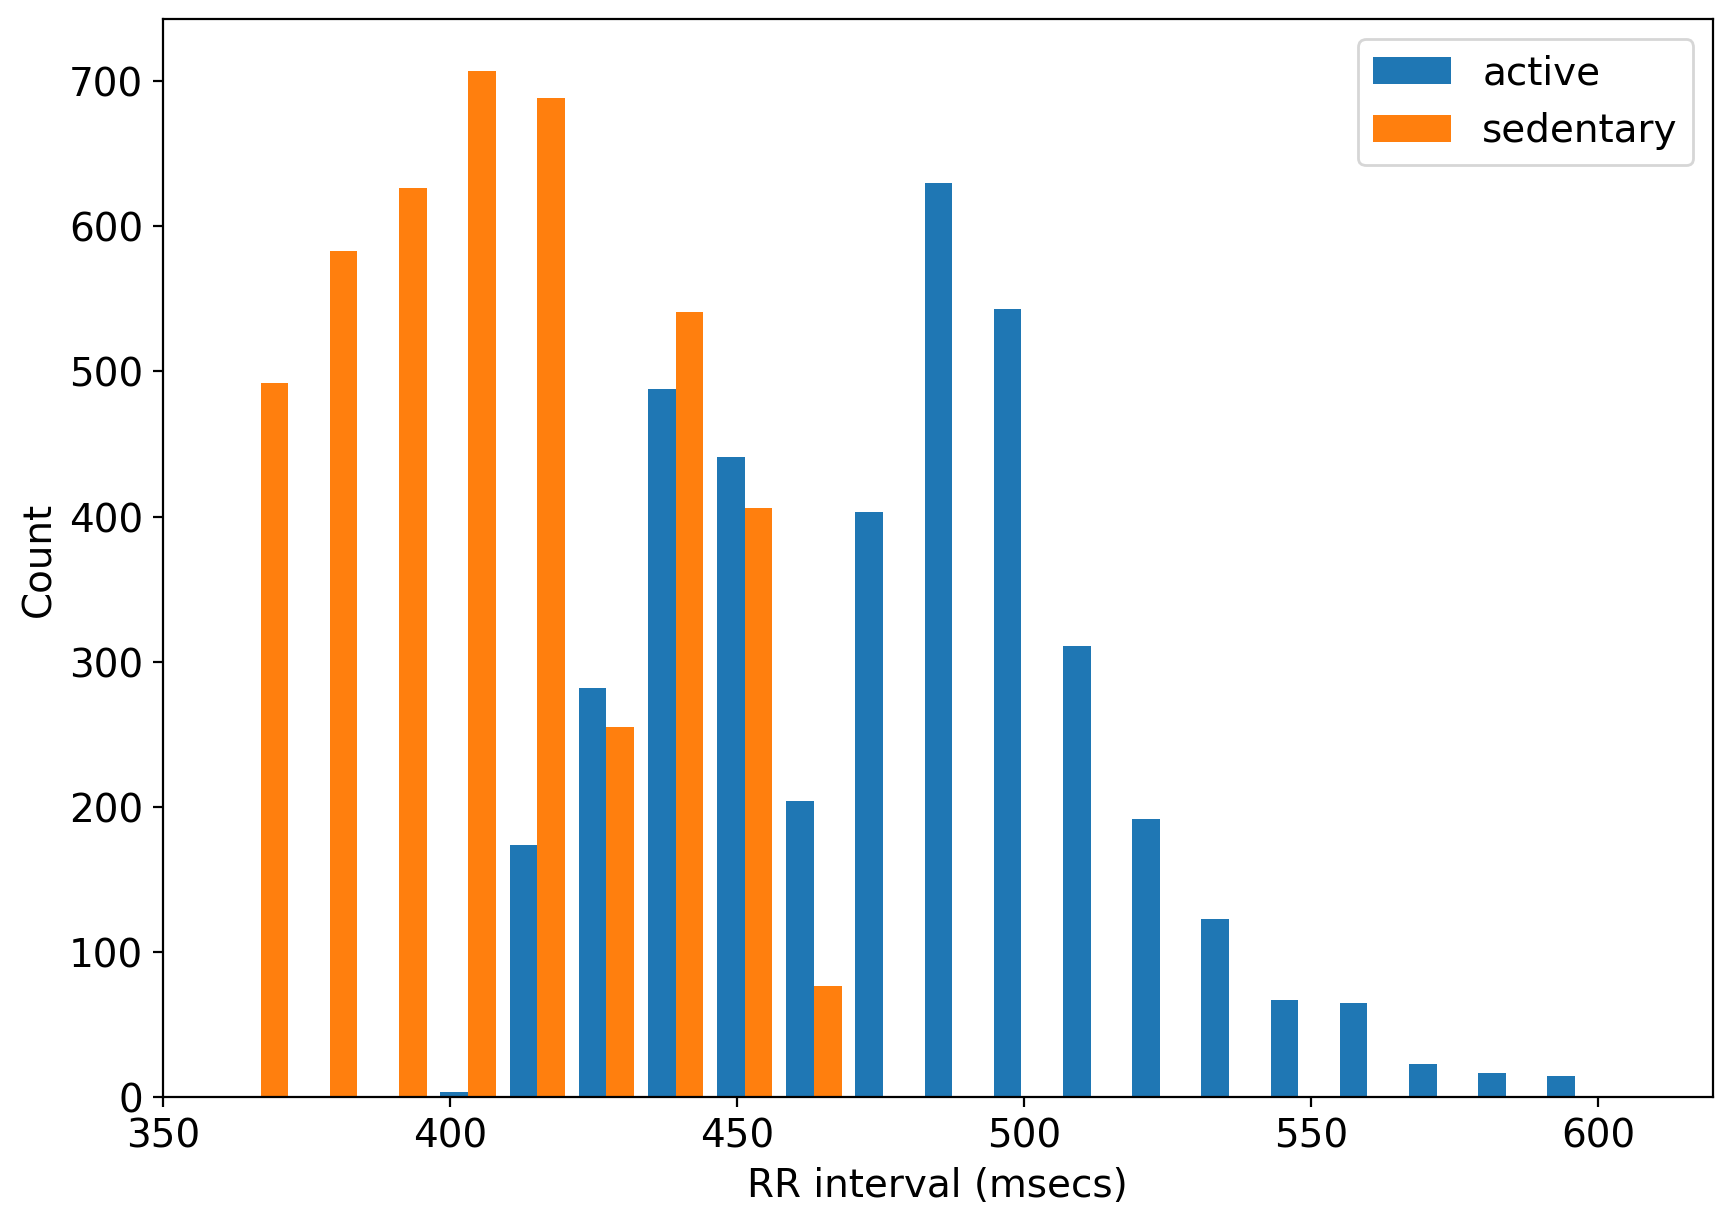

In [164]:
# plot side-by-side histograms; just another way to compare the data, comment if not used
plt.figure(figsize=(10,7))
plt.hist([RRs_act,RRs_sed],bins=20,label=['active','sedentary'],align='mid')
plt.xlabel('RR interval (msecs)')
plt.ylabel('Count')
plt.xlim(350,620)
plt.legend();

From the above graphs, we can see that there is a clear shift in the sedentary distribution relative to active. But since we know some subjects have different numbers of observations, how much of an issue is it to pool these? To understand the potential problems with this approach, we will look just at the active data. As we saw above from the kernel density estimates (KDEs), there is one subject (S10; remember we start with index 0) with larger RR values. What happens if we remove this subject from the sample?

In [165]:
# remove 'outlier' with larger RR values; only run once so that n=10
myList=actives

indexes = [10]
for index in sorted(indexes, reverse=True):
    del myList[index]
    
print(len(myList))

10


In [166]:
# rerun data pooling with restricted sample (minus one subject)
pooledAct_minus=sum(myList,[])

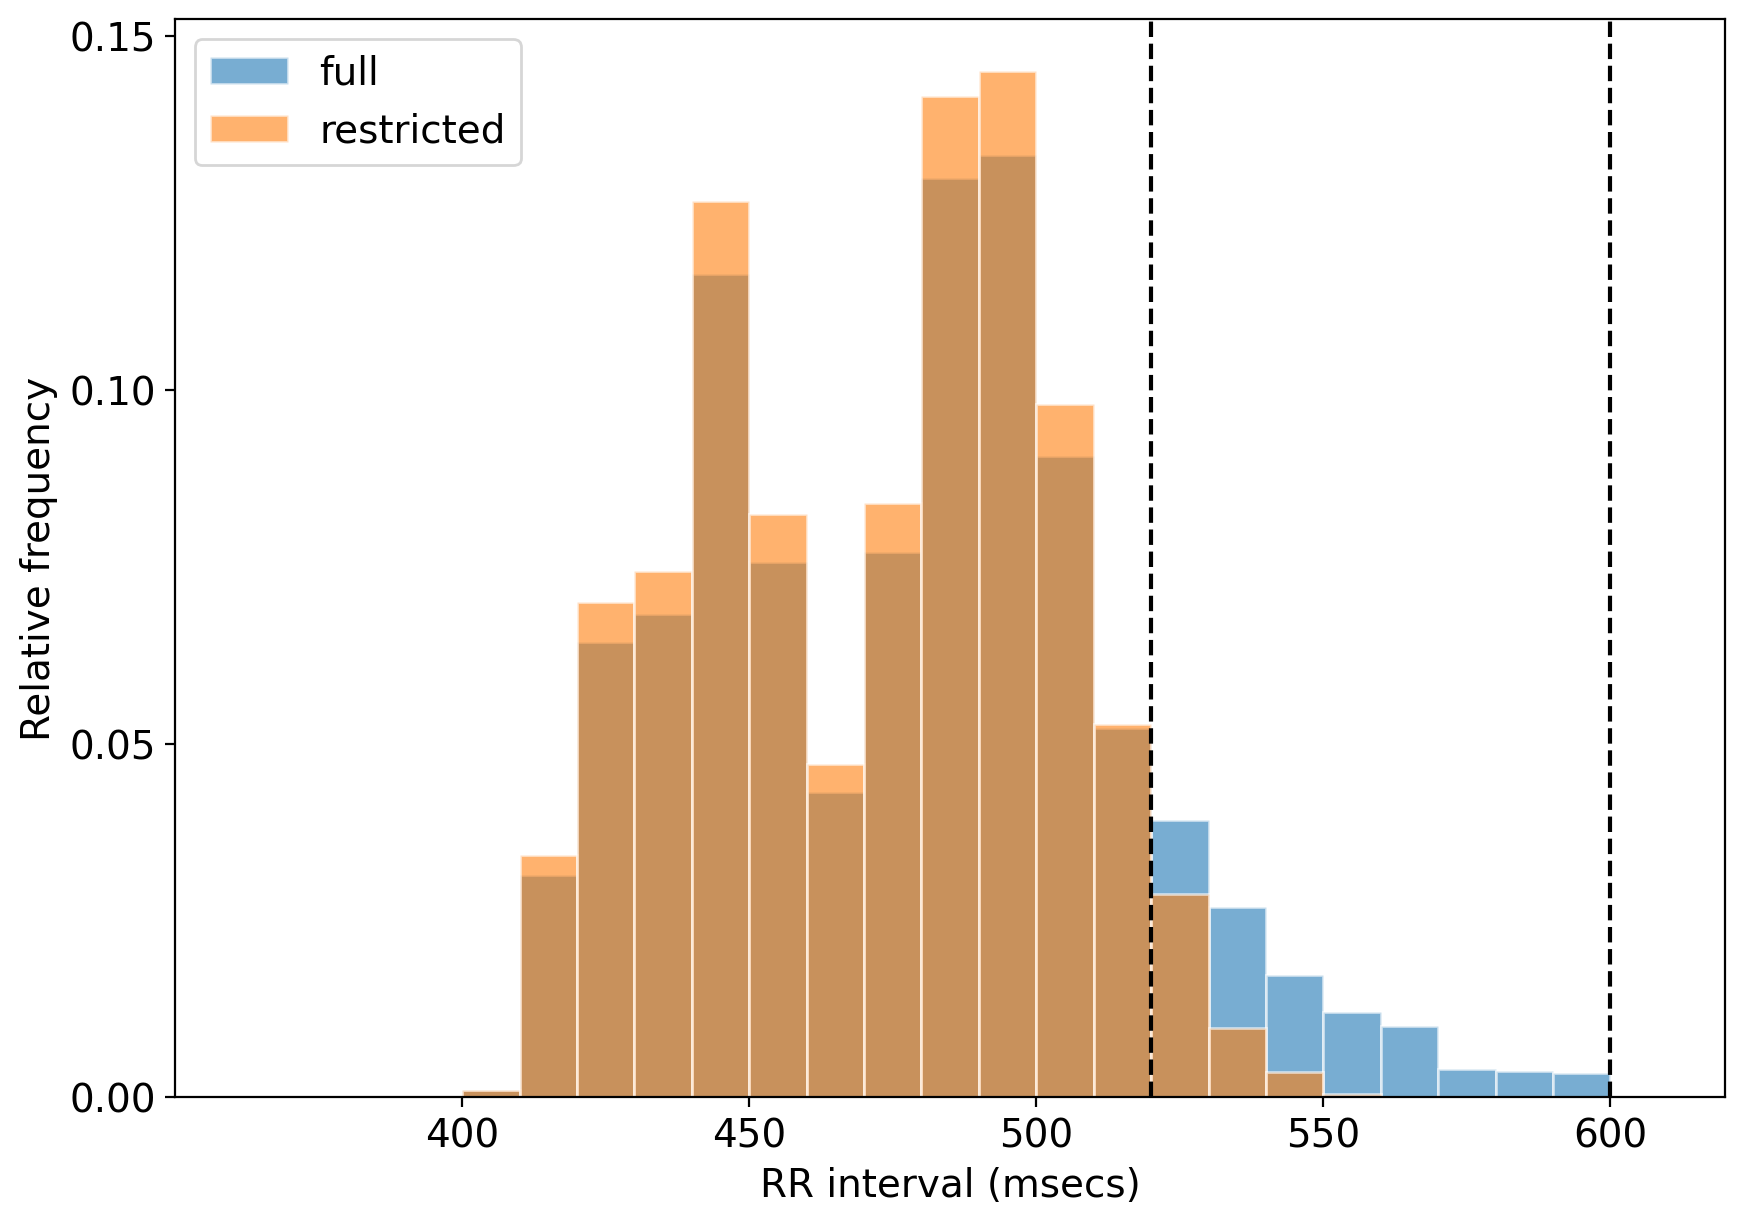

In [212]:
# plot overlapping histograms to compare the two groups with pooled observations
plt.figure(figsize=(10,7))
plt.hist(RRs_act,weights=np.zeros_like(RRs_act) + 1. / RRs_act.size,bins=np.arange(340,620,10),align='mid',fill=bool,\
         linewidth=1.0,edgecolor='white',label='full',alpha=0.6)
plt.hist(pooledAct_minus,weights=np.zeros_like(pooledAct_minus) + 1. / len(pooledAct_minus),bins=np.arange(340,620,10),align='mid',fill=bool,\
         linewidth=1.0,edgecolor='white',label='restricted',alpha=0.6)
plt.axvline(x=5,color='k',ls='--')
plt.axvline(x=8,color='k',ls='--')
plt.legend()
plt.xlim(350,620)
plt.xticks(np.arange(400,601, step=50))
plt.yticks(np.arange(0,0.17, step=0.05))
plt.axvline(x=520,color='k',ls='--') 
plt.axvline(x=600,color='k',ls='--')
plt.xlabel('RR interval (msecs)')
plt.ylabel('Relative frequency');
plt.legend(loc='upper left');#bbox_to_anchor=(0.94,1.0));

The graph shows that there are several right-hand peaks in the distribution that pull the distribution out to a maximum of nearly 600ms. These peaks disappear (i.e. max runs out to around 540) when subject S10 is removed from the sample. This is not to suggest that we should remove this subject from all analyses (we'll put it back in later). Rather, it demonstrates how pooling data, especially when we have subjects with large and disparate numbers of observations, can skew the distribution.

## Calculating and graphing empirical distribution functions
If we should not pool the data, what approach can we take? As we mentioned above, our strategy (described in more detail in the accompanying paper) is to first calculate the EDF for a single subject from a single group (e.g. active or sedentary). Then, we take the point-wise average over those EDFs to generate the group EDF. This helps us to avoid pseudoreplication, as each subject is represented only once, and minimizes the effect of any subjects with large numbers of observations. Then, we can properly compare the two groups. But first, we recalculate all the RR intervals to make sure we've put back the subjects we removed above, and once again have a complete data set. 

In [168]:
# use indices to pull RR intervals for that same period 
exerData=[]
for n in range(0,len(sameLevels)):
    datapts=sameLevels[n]['RRdata_rem'][starts[n]:ends[n]]
    exerData.append(datapts)
    
# specify which subjects in data are active versus sedentary
actInds=[0,1,2,3,11,12,13,17,20,22,24] # active
sedInds=[4,5,6,7,8,14,15,19,25,26] # sedentary

# extract data for active subjects; sample sizes should be 11 and 10, respectively
actives = [exerData[i] for i in actInds]
print(len(actives)) # sample size

# extract data for sedentary subjects
sedentaries = [exerData[i] for i in sedInds]
print(len(sedentaries)) # sample size

11
10


In [169]:
# re-create dictionary with keys for the two groups
groups={'active':actives,'sedentary':sedentaries}

In [170]:
# run functions to calculate EDFs for single subjects and group; will calculate domains
ax=list(); pn=0
for k in groups.keys():
    rm = RepeatedMeasures(sampleList=groups[k])
    print('Range for %s: [%g,%g], with %d samples'%(k,rm.pooled.sample_Min,rm.pooled.sample_Max,rm.nSamples))
    rm.mean_EDF_values, rm.mean_EMF_values = rm.graph_meanEDF(ax=1,nPts=100,sampleColor='black',meanColor='blue',graph=0)
    pn+=1

Range for active: [408,602], with 11 samples
Range for sedentary: [361,470], with 10 samples


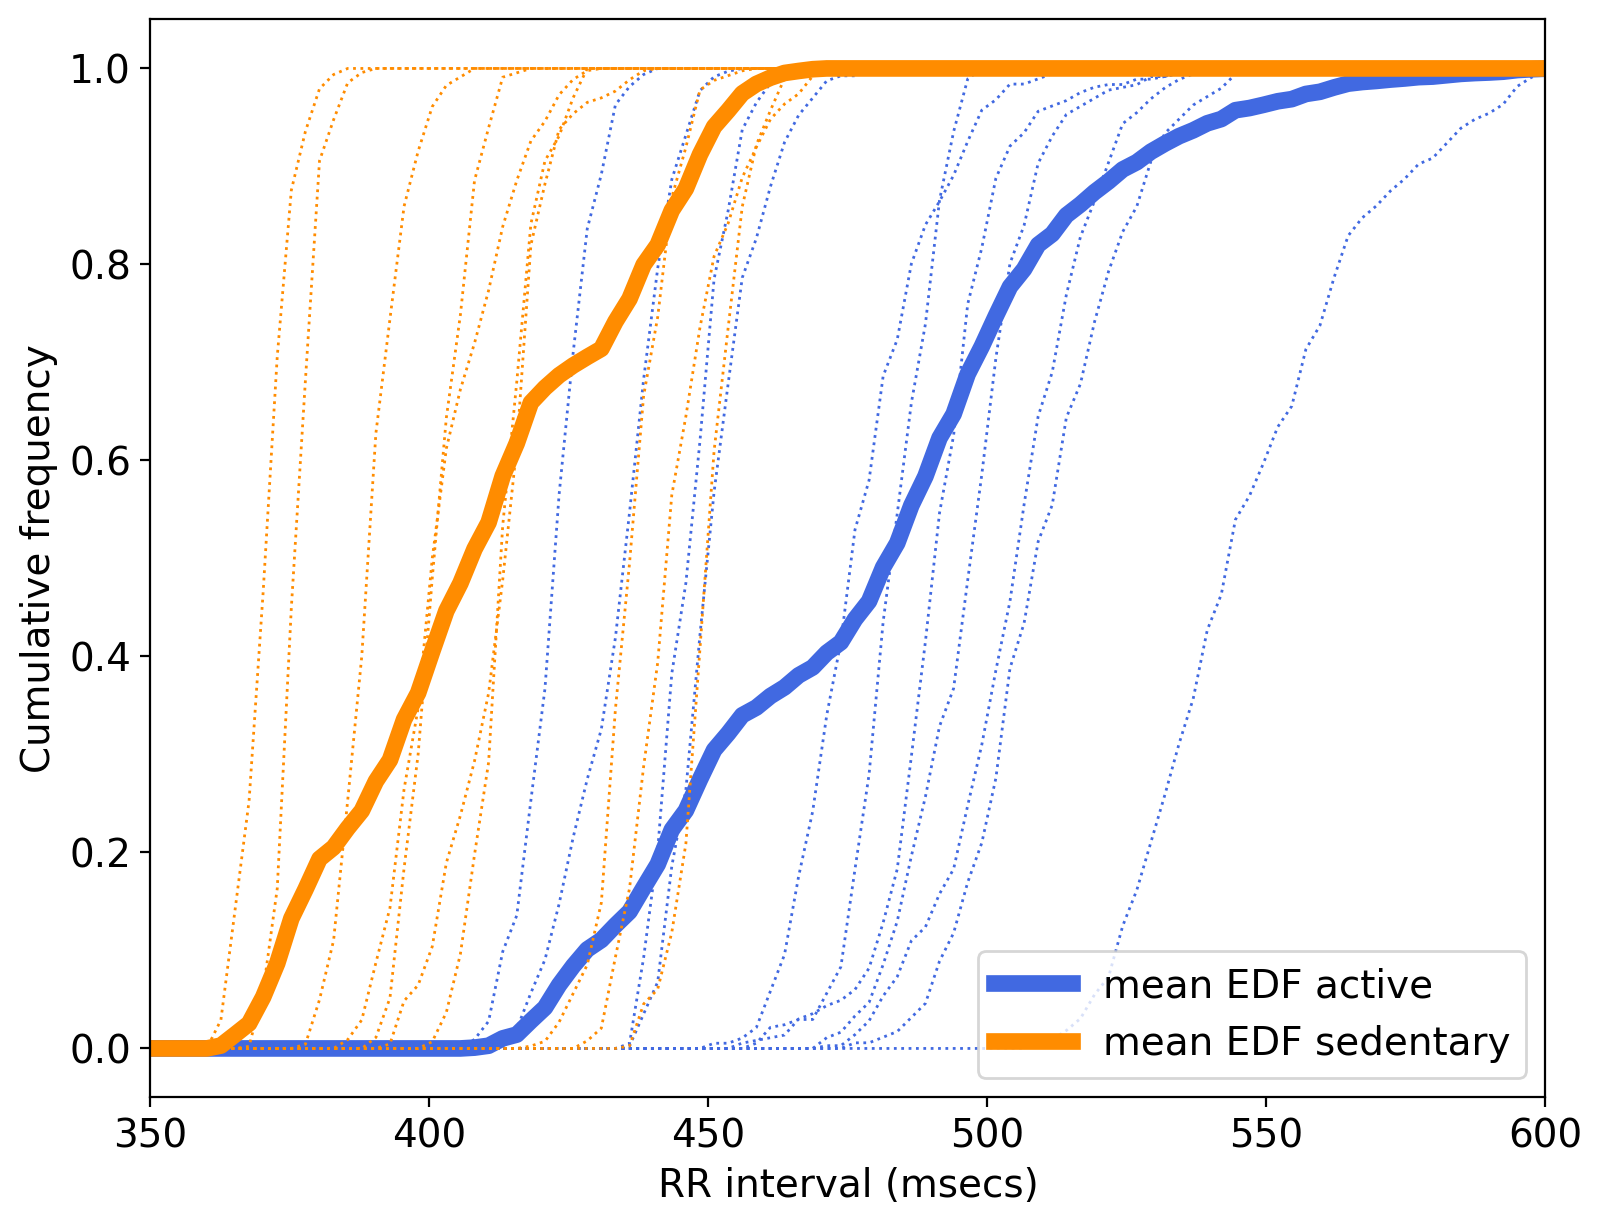

In [171]:
# calculate and plot EDFs for the two groups with n points for 'interpolation'
colors={'active':'royalblue','sedentary':'darkorange'}
minRR=350; maxRR=600; nPts = 100; commonDomain = np.linspace(minRR,maxRR,nPts)
fig=plt.figure(figsize=(9,7))
ax1= fig.add_subplot(111)
G = dict();
for k in groups.keys():
    nSamples = len(groups[k])
    str0=k
    G[k]= RepeatedMeasures(groups[k])
    G[k].label= k
    G[k].domain = commonDomain
    mean_EDF_values, rm.mean_EMF_values =\
    G[k].graph_meanEDF(ax=ax1,nPts=nPts,sampleColor=colors[k],meanColor=colors[k],graph=1)
    ax1.set_xlabel('RR interval (msecs)')
    ax1.set_ylabel('Cumulative frequency')
    ax1.set_xlim(350,maxRR)

In the above graph, we can see each of the individual subject EDFs (thin, dotted lines) and the average EDFs for each group (thick, solid lines). There is a clear left-shift in EDFs (individual and average) for the sedentary group, i.e. the RR are generally shorter than in active subjects. The difference looks large, but let's explore how we would formally test this.

## Performing statistical testing
Now, we want to test whether the observed difference between the two groups (WT and Slo) on the burst measure of interest (cycle duration) is statistically significant. To do this, we first pull the values from the group (averaged) EDF curves, which will be the values that go into our statistical test. Because the data distributions are non-normal, we use a non-parametric test, the Wilcoxon rank sum test. For more information on why we selected this test, please see the details and citations in our accompanying paper.

Since our technique relies on a form of boostrapping or interpolation - extracting values from the group EDFs - we can run a sensitivity test to see how the number of extracted values affects the result. To do this, we set the theoretical sample size between 2 and 40 values, increasing in steps of 1. We then use a random number generator to extract that number of values but at different points along the group EDFs. We run the statistical tests on these samples, and repeat the process 10 times for each sample size. Graphing the result lets us see how many of these tests hit below the established threshold for significance, p<0.05.

In [172]:
# set the samples to be compared and print sample sizes
# act_samples and sed_samples are lists, each item in the list is a sample of RR intervals from one subject
act_samples = groups['active']; nAct = len(act_samples); print('%d Active RR samples'%nAct)
sed_samples = groups['sedentary']; nSed = len(sed_samples); print('%d Sedentary RR samples'%nSed)
#
#print(act_samples[0])

11 Active RR samples
10 Sedentary RR samples


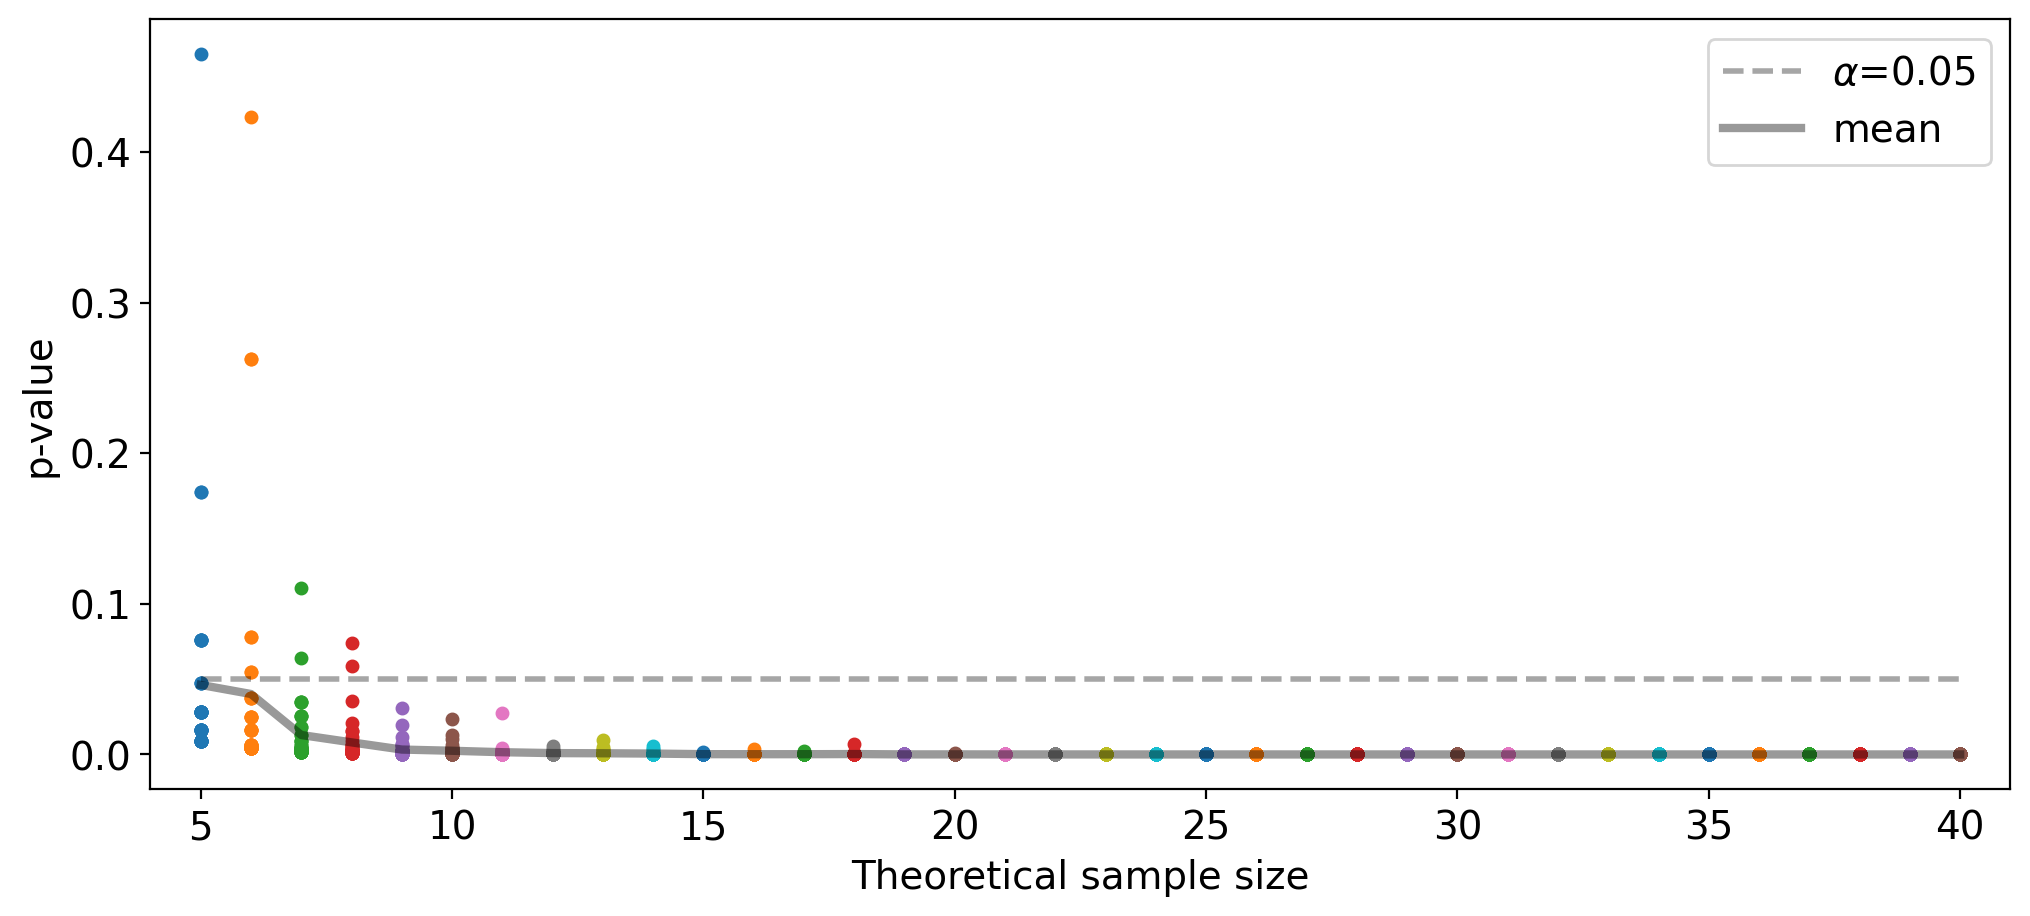

In [173]:
WRS_pval= meanEDF_WRST_sensitivity(G1=act_samples, G2=sed_samples, Ns = np.arange(5,41,1), repeats=40, plotResults=1)

The above figure shows that with small theoretical sample sizes, there is large variability in the resultant p-values. However, the variability decreases as the sample size increases, and once it hits around 20, the p-values are all below 0.05.